In [1]:
from hcipy import *
import matplotlib.pyplot as plt
import numpy as np
from photutils import CircularAperture, CircularAnnulus

In [2]:
pupil_grid = make_pupil_grid(256, 1.5)
focal_grid = make_focal_grid(8, 12)
prop = FraunhoferPropagator(pupil_grid, focal_grid)

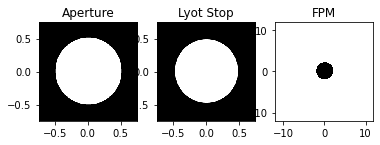

In [3]:
aperture = evaluate_supersampled(circular_aperture(1), pupil_grid, 4)
lyot_mask = evaluate_supersampled(circular_aperture(.95), pupil_grid, 4)
fpm_inverse = evaluate_supersampled(circular_aperture(4), focal_grid, 4)
fpm = fpm_inverse == 0
plt.subplot(1, 3, 1)
plt.title('Aperture')
imshow_field(aperture, cmap='gray')
plt.subplot(1, 3, 2)
plt.title('Lyot Stop')
imshow_field(lyot_mask, cmap='gray')
plt.subplot(1, 3, 3)
plt.title('FPM')
imshow_field(fpm, cmap='gray')
plt.show()

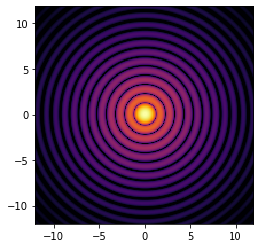

In [4]:
wf = Wavefront(aperture)
img_ref = prop(wf).intensity

imshow_field(np.log10(img_ref/img_ref.max()), vmin=-5, cmap='inferno')

In [5]:
charge = 2
coro = VortexCoronagraph(pupil_grid, charge)
lyot_coro = LyotCoronagraph(pupil_grid, fpm)
lyot_stop = Apodizer(lyot_mask)

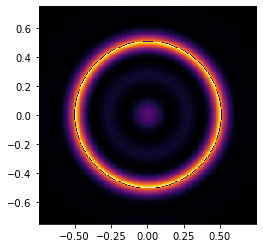

In [6]:
wf = Wavefront(aperture)
lyot_plane = lyot_coro(wf)

plt.subplot()
imshow_field(lyot_plane.intensity, cmap='inferno')

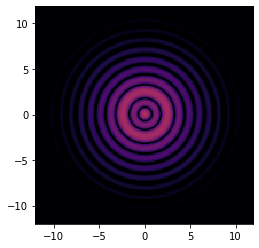

In [7]:
post_lyot_mask = lyot_stop(lyot_plane)
img = prop(post_lyot_mask).intensity

imshow_field(np.log10(img /img_ref.max()), vmin=-5, vmax=0, cmap='inferno')
# throw in a circle of the FPM size -- 
plt.show()

# make a contrast curve
# VIP


In [8]:
def make_iris_aperture(normalized=False, with_spiders=False, with_segment_gaps=False, gap_padding=0, segment_transmissions=1, return_header=False, return_segments=False, pupil='default', actual_flat='default'):
    pupil_diameter = 4.242 if pupil == 'default' else pupil #mm actual circumscribed diameter, used for lam/D calculations other measurements normalized by this diameter
    actual_segment_flat_diameter = np.sqrt(3)/2 * .7  #mm actual segment flat-to-flat diameter
    if actual_flat != 'default':
        actual_segment_flat_diameter = actual_segment_flat_diameter * actual_flat
    actual_segment_gap = 0.001 #mm actual gap size between segments
    spider_width = 1*0.00850 #mm actual strut size
    gap_padding = 10.
    segment_gap = actual_segment_gap * gap_padding #padding out the segmentation gaps so they are visible and not sub-pixel
    segment_transmissions = 1.

    segment_flat_diameter = actual_segment_flat_diameter - (segment_gap - actual_segment_gap)
    segment_circum_diameter = 2 / np.sqrt(3) * segment_flat_diameter #segment circumscribed diameter

    num_rings = 3 #number of full rings of hexagons around central segment

    segment_positions = make_hexagonal_grid(actual_segment_flat_diameter + actual_segment_gap, num_rings)
    segment_positions = segment_positions.subset(lambda grid: ~(circular_aperture(segment_circum_diameter)(grid) > 0))

    segment = hexagonal_aperture(segment_circum_diameter, np.pi / 2)

    spider1 = make_spider_infinite([0, 0], 0, spider_width) # origin, degree, width 
    spider2 = make_spider_infinite([0, 0], 60, spider_width) 
    spider3 = make_spider_infinite([0, 0], 120, spider_width)
    spider4 = make_spider_infinite([0, 0], 180, spider_width)
    spider5 = make_spider_infinite([0, 0], 240, spider_width)
    spider6 = make_spider_infinite([0, 0], 300, spider_width)

    segmented_aperture = make_segmented_aperture(segment, segment_positions, segment_transmissions, return_segments=return_segments)
    
    def func(grid):
        res = segmented_aperture(grid) * spider1(grid) * spider2(grid) * spider3(grid)* spider4(grid) * spider3(grid)* spider5(grid) * spider6(grid) # * coro(grid)
        return Field(res, grid)
    
    return func

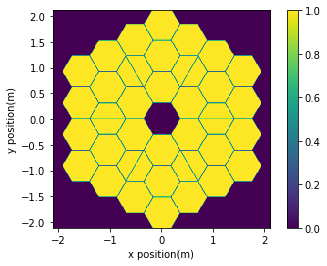

In [9]:
telescope_diameter = 4.242
num_pupil_pixels = 240 #??
pupil_grid_diameter = telescope_diameter
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)

iris_aperture  =evaluate_supersampled(make_iris_aperture(telescope_diameter), pupil_grid, 6)

imshow_field(iris_aperture)
plt.xlabel('x position(m)')
plt.ylabel('y position(m)')
plt.colorbar()
plt.show()
#plt.savefig('test.png')

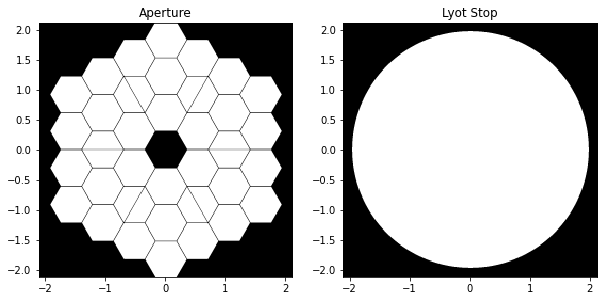

In [10]:
aperture = iris_aperture
lyot_mask = evaluate_supersampled(circular_aperture(.98*4), pupil_grid, 4)
fig = plt.subplots(figsize=(10,20))
plt.subplot(1, 2, 1)
plt.title('Aperture')
imshow_field(aperture, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Lyot Stop')
imshow_field(lyot_mask, cmap='gray')

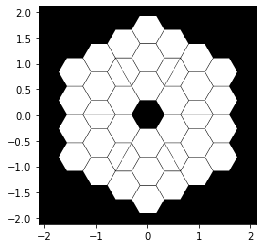

In [11]:
# make a test undersized iris ap as LS
telescope_diameter = 4.242
num_pupil_pixels = 240 #??
pupil_grid_diameter = telescope_diameter
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)
iris_ls= evaluate_supersampled(make_iris_aperture(telescope_diameter, actual_flat=.9), pupil_grid, 6)
imshow_field(iris_ls, cmap='gray')

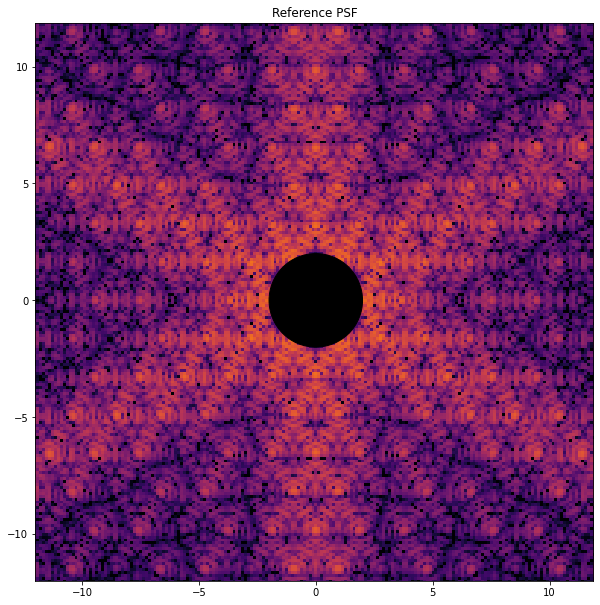

In [12]:
pupil_grid = make_pupil_grid(256, 1.5) # this might be totally wrong whoops
focal_grid = make_focal_grid(8, 12)  # same tho
prop = FraunhoferPropagator(pupil_grid, focal_grid)

wf = Wavefront(aperture)
img_ref = prop(wf).intensity

fpm_inverse = evaluate_supersampled(circular_aperture(4), focal_grid, 4)
fpm = fpm_inverse == 0

fig, ax = plt.subplots(figsize=(10,20))
plt.title('Reference PSF')
imshow_field(np.log10(img_ref/img_ref.max()), vmin=-10, cmap='inferno')
circle1 = plt.Circle((0, 0), 4/2, color='black')
ax.add_artist(circle1)
plt.show()


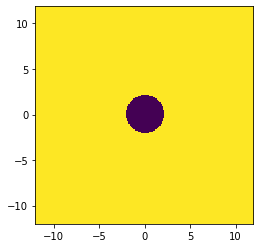

In [13]:
imshow_field(fpm)

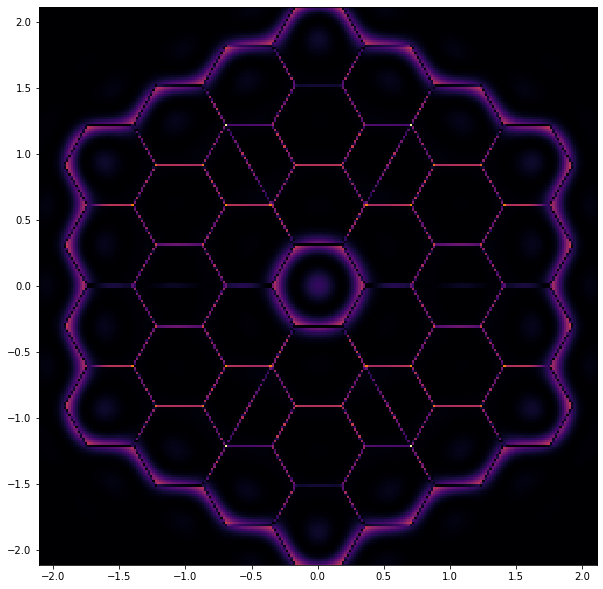

In [14]:
lyot_coro = LyotCoronagraph(pupil_grid, fpm)
lyot_stop = Apodizer(lyot_mask)
lyot_stop_iris = Apodizer(iris_ls)
wf = Wavefront(aperture)
lyot_plane = lyot_coro(wf)
fig, ax = plt.subplots(figsize=(10,20))
imshow_field(lyot_plane.intensity, cmap='inferno')

Text(0.5, 1.0, 'Iris-shaped LS')

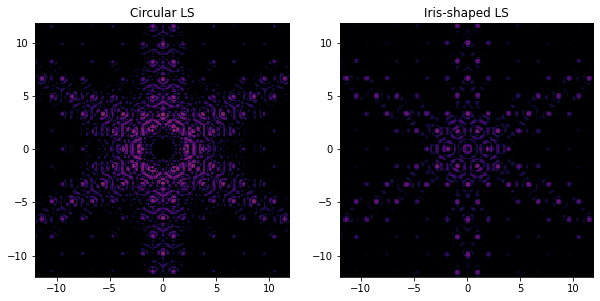

In [15]:
post_lyot_mask = lyot_stop(lyot_plane)
post_lyot_mask_iris = lyot_stop_iris(lyot_plane)
img_circular = prop(post_lyot_mask).intensity
img_iris = prop(post_lyot_mask_iris).intensity
fig, ax = plt.subplots(figsize=(10,20))
plt.subplot(1, 2, 1)
imshow_field(np.log10(img_circular/img_ref.max()), vmin=-6, vmax=0, cmap='inferno')
circle1 = plt.Circle((0, 0), 2, color='cyan', fill=False)
plt.title('Circular LS')
plt.subplot(1, 2, 2)
imshow_field(np.log10(img_iris /img_ref.max()), vmin=-6, vmax=0, cmap='inferno')
circle1 = plt.Circle((0, 0), 2, color='cyan', fill=False)
plt.title('Iris-shaped LS')

(192, 192)


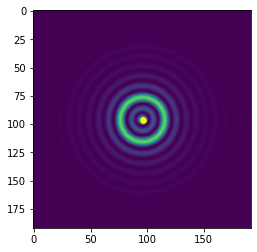

In [16]:
img_array = img.shaped
print(img_array.shape)
plt.imshow(img_array)
plt.scatter(192/2, 192/2, color='yellow', s=30)


In [17]:
# Calculate raw contrast 
# right now set ring width of 3 px
# also the rings don't overlap
# I think ideally this should be in lam/d?
def calculate_raw_contrast(image_data, max_ref=1):
    
    origin = (192/2, 192/2)
    max_edge = int(192/2)
    annulus_width = 3

    ring_edges = np.arange(4, max_edge, 3)
    ring_sums = []

    for ring_edge in range(4, max_edge, 3):
        #print(ring_edge-annulus_width, ring_edge)
        ring = CircularAnnulus(origin, r_in=ring_edge-annulus_width, r_out=ring_edge)
        ring_mask = ring.to_mask(method='center')
        image_ring = ring_mask.multiply(image_data/max_ref)
        ring_sums.append(np.std(image_ring))
    return ring_edges, ring_sums

#plt.plot(ring_edges, ring_sums)


In [18]:
def generate_coronagraph(fpm_diameter, lyot_diameter, plot=False, vmin=-5, vmax=0, aperture_type='iris'):
    pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)
    
    iris_aperture  = evaluate_supersampled(make_iris_aperture(telescope_diameter), pupil_grid, 6)
    circular = evaluate_supersampled(circular_aperture(4), pupil_grid, 6)
    aperture = iris_aperture if aperture_type == 'iris' else circular
    
    lyot_mask = evaluate_supersampled(circular_aperture(lyot_diameter*4), pupil_grid, 4)

    pupil_grid = make_pupil_grid(256, 1.5) # this might be totally wrong whoops
    focal_grid = make_focal_grid(8, 12)  # same tho
    prop = FraunhoferPropagator(pupil_grid, focal_grid)

    wf = Wavefront(aperture)
    img_ref = prop(wf).intensity

    fpm_inverse = evaluate_supersampled(circular_aperture(fpm_diameter), focal_grid, 4)
    fpm = fpm_inverse == 0
    lyot_coro = LyotCoronagraph(pupil_grid, fpm)
    lyot_stop = Apodizer(lyot_mask)
    wf = Wavefront(aperture)
    lyot_plane = lyot_coro(wf)
    post_lyot_mask = lyot_stop(lyot_plane)
    img = prop(post_lyot_mask).intensity
    if plot:
        imshow_field(np.log10(img /img_ref.max()), vmin=vmin, vmax=vmax, cmap='inferno')
    return img.shaped, img_ref.max()


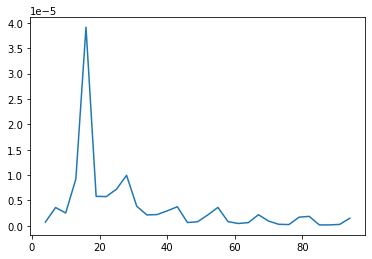

In [19]:
test, max_ref = generate_coronagraph(3, .9)
edges, sums = calculate_raw_contrast(test, max_ref)

plt.clf()
plt.plot(edges, sums)
#plt.imshow(np.log10(test))

In [20]:
fpm_d = np.arange(.8, 4, .1)
lyot_d = np.arange(.9, .99, .01)

<Figure size 432x288 with 0 Axes>

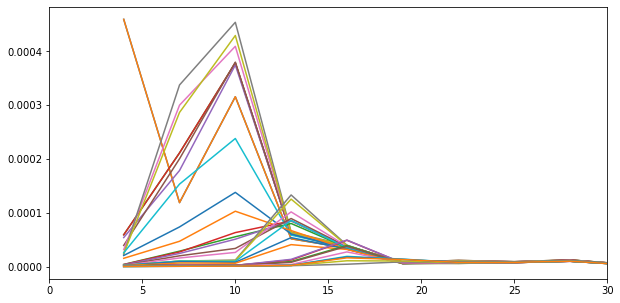

In [21]:
# For the iris

plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
sum_check = 1000
fpm_val, lyot_val = 0, 0
lyot_const = .9
for val in fpm_d:
    data_out, max_ref = generate_coronagraph(val, lyot_const)
    ring_edges, ring_sums = calculate_raw_contrast(data_out, max_ref)
    plt.plot(ring_edges, ring_sums)
    plt.xlim(0, 30)
    if np.sum(ring_sums) < sum_check:
        sum_check = np.max(ring_sums)
        fpm_val = val
        lyot_val = lyot_const
        
    
    

In [64]:
sum_check, fpm_val, lyot_val

(3.9127614943614e-05, 2.999999999999999, 0.9)

<Figure size 432x288 with 0 Axes>

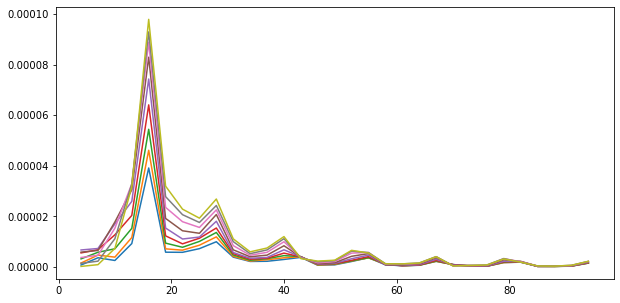

In [65]:
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
sum_check = 1000
fpm_val, lyot_val = 0, 0
fpm_const = 3
for val in lyot_d:
    data_out, max_ref = generate_coronagraph(fpm_const, val)
    ring_edges, ring_sums = calculate_raw_contrast(data_out, max_ref)
    plt.plot(ring_edges, ring_sums)
    if np.sum(ring_sums) < sum_check:
        sum_check = np.sum(ring_sums)
        fpm_val = fpm_const
        lyot_val = val
        

In [66]:
sum_check, fpm_val, lyot_val

(0.00011723574669501177, 3, 0.9)

(Field([[4.17741483e-06, 1.49822711e-07, 7.75280361e-08, ...,
         3.85336985e-06, 7.75280361e-08, 1.49822711e-07],
        [1.77414231e-05, 5.99715511e-06, 5.80165069e-10, ...,
         3.29199474e-07, 5.80165069e-10, 5.99715511e-06],
        [1.12645499e-05, 1.03313780e-05, 1.69206699e-07, ...,
         6.56375178e-06, 1.69206699e-07, 1.03313780e-05],
        ...,
        [3.84101577e-06, 1.75079976e-05, 4.35919310e-07, ...,
         5.30657207e-06, 4.35919310e-07, 1.75079976e-05],
        [1.12645499e-05, 1.03313780e-05, 1.69206699e-07, ...,
         6.56375178e-06, 1.69206699e-07, 1.03313780e-05],
        [1.77414231e-05, 5.99715511e-06, 5.80165069e-10, ...,
         3.29199474e-07, 5.80165069e-10, 5.99715511e-06]]),
 Field(122.80917305))

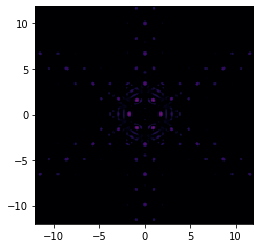

In [67]:
generate_coronagraph(3, .9, True, vmin=-5)

<Figure size 432x288 with 0 Axes>

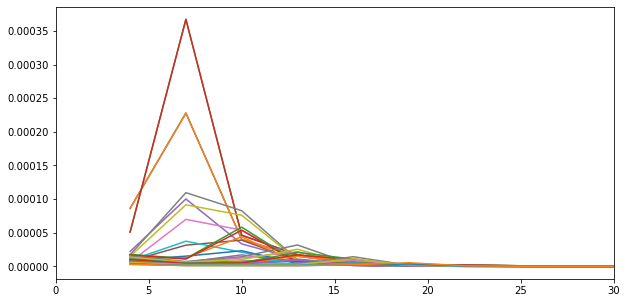

In [68]:
# For circular

plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
sum_check = 1000
fpm_val, lyot_val = 0, 0
lyot_const = .9
for val in fpm_d:
    data_out, max_ref = generate_coronagraph(val, lyot_const, aperture_type='circular')
    ring_edges, ring_sums = calculate_raw_contrast(data_out, max_ref)
    plt.plot(ring_edges, ring_sums)
    plt.xlim(0, 30)
    if np.sum(ring_sums) < sum_check:
        sum_check = np.max(ring_sums)
        fpm_val = val
        lyot_val = lyot_const
        
    
    

In [69]:
sum_check, fpm_val, lyot_val

(1.0878915435406027e-05, 2.3, 0.9)

<Figure size 432x288 with 0 Axes>

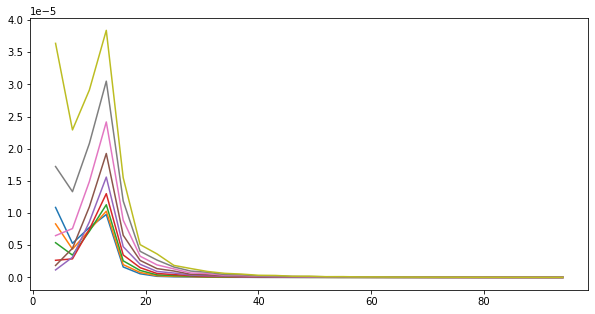

In [74]:
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
sum_check = 1000
fpm_val, lyot_val = 0, 0
fpm_const = 2.3
for val in lyot_d:
    data_out, max_ref = generate_coronagraph(fpm_const, val, aperture_type='circular')
    ring_edges, ring_sums = calculate_raw_contrast(data_out, max_ref)
    plt.plot(ring_edges, ring_sums)
    if np.sum(ring_sums) < sum_check:
        sum_check = np.sum(ring_sums)
        fpm_val = fpm_const
        lyot_val = val
   

In [75]:
sum_check, fpm_val, lyot_val

(3.2336749682641104e-05, 2.3, 0.92)

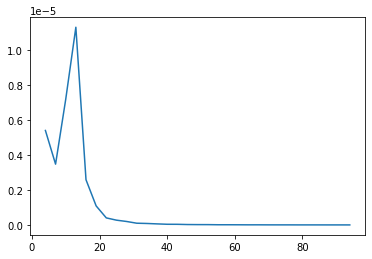

In [76]:
test, max_ref = generate_coronagraph(2.3, .92, aperture_type='circular')
edges, sums = calculate_raw_contrast(test, max_ref)

plt.clf()
plt.plot(edges, sums)
#plt.imshow(np.log10(test))

(Field([[3.37041527e-06, 1.43864778e-10, 2.40045376e-10, ...,
         4.17352799e-06, 2.40045376e-10, 1.43864778e-10],
        [1.44209012e-05, 4.99059194e-06, 2.58021773e-08, ...,
         2.36675190e-08, 2.58021773e-08, 4.99059194e-06],
        [9.50013629e-06, 1.15017043e-05, 4.04589011e-09, ...,
         4.94290944e-06, 4.04589011e-09, 1.15017043e-05],
        ...,
        [4.21313903e-06, 2.11104949e-05, 9.93927520e-07, ...,
         5.69493128e-06, 9.93927520e-07, 2.11104949e-05],
        [9.50013629e-06, 1.15017043e-05, 4.04589011e-09, ...,
         4.94290944e-06, 4.04589011e-09, 1.15017043e-05],
        [1.44209012e-05, 4.99059194e-06, 2.58021773e-08, ...,
         2.36675190e-08, 2.58021773e-08, 4.99059194e-06]]),
 Field(122.80917305))

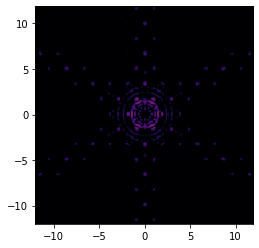

In [78]:
generate_coronagraph(2.3, .9, True, vmin=-5)

In [26]:
import vip_hci 
# data cube --> should allow with reshaping
# paralltic angles ??? 
# fwhm -- supposed optional? --> should be in pixel size (lam/d)
# psf_template -- what if I don't want a fake companion? --> how much has postprocessing attenuated flux of feasible companion
# PSF template WON't be neccesarry for contrast curves 
algo = vip_hci.pca.pca 
# coronagraph throughput 
# how much flux from before (sum of pupil image)
# vs how much we end up with in pupil plane 
# starlight supression but not how much coronagraph zapped 
starphot = img_ref.max()
pxscale = (192**2)/16
psf_template = np.array(np.zeros((192,192), dtype=float))

#vip_hci.metrics.contrcurve.contrast_curve(contrast_curve_data, np.array([0,0]), psf_template, 4, pxscale, np.array([starphot,starphot]), algo)
frame_nofc = algo(contrast_curve_data/starphot, angle_list=np.array([0,0]), verbose=False)
wedge=(0,360)
noise, vector_radd = vip_hci.metrics.contrcurve.noise_per_annulus(frame_nofc, separation=2, fwhm=2, wedge=wedge)
inner_rad=0
vector_radd = vector_radd[inner_rad-1:]
noise = noise[inner_rad-1:]

/opt/anaconda3/envs/hicat-package/lib/python3.6/site-packages/hciplot/hciplot.py:28: MatplotlibDeprecationWarning: Passing raw data via parameters data and lut to register_cmap() is deprecated since 3.3 and will become an error two minor releases later. Instead use: register_cmap(cmap=LinearSegmentedColormap(name, data, lut))
  register_cmap('ds9cool', data=ds9cool)
/opt/anaconda3/envs/hicat-package/lib/python3.6/site-packages/hciplot/hciplot.py:29: MatplotlibDeprecationWarning: Passing raw data via parameters data and lut to register_cmap() is deprecated since 3.3 and will become an error two minor releases later. Instead use: register_cmap(cmap=LinearSegmentedColormap(name, data, lut))
  register_cmap('ds9heat', data=ds9heat)


NameError: name 'contrast_curve_data' is not defined

In [ ]:
from photutils.datasets import make_100gaussians_image
from photutils import CircularAperture, CircularAnnulus
data = make_100gaussians_image()
position = [(145.1, 168.3), (84.5, 224.1), (48.3, 200.3)]
aperture = CircularAperture(position, r=5)
annulus_aperture = CircularAnnulus(position, r_in=10, r_out=15)
             

In [ ]:
plt.imshow(data, cmap='viridis', vmin=np.mean(data)-np.std(data), vmax=np.max(data)+np.std(data))
plt.scatter([pos[0] for pos in position], [pos[1] for pos in position])
plt.xlim(0,160)
plt.ylim(140,240)
annulus_masks = annulus_aperture.to_mask(method='center')

In [ ]:
plt.imshow(annulus_masks[0], interpolation='nearest')
plt.colorbar()

In [ ]:
annulus_data = annulus_masks[0].multiply(data)
plt.imshow(annulus_data)
np.sum(annulus_data)
np.sum(data)

In [ ]:
plt.imshow(data_out)

In [ ]:
# Now for circular

plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
sum_check = 1000
fpm_val, lyot_val = 0, 0
lyot_const = .9
for val in fpm_d:
    data_out = generate_coronagraph(val, lyot_const, aperture_type='circular')
    ring_edges, ring_sums = calculate_raw_contrast(data_out)
    plt.plot(ring_edges, ring_sums)
    if np.sum(ring_sums) < sum_check:
        sum_check = np.sum(ring_sums)
        fpm_val = val
        lyot_val = lyot_const

In [ ]:
sum_check, fpm_val, lyot_val

In [ ]:
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
sum_check = 1000
fpm_val, lyot_val = 0, 0
fpm_const = 3.8
for val in lyot_d:
    data_out = generate_coronagraph(fpm_const, val, aperture_type='circular')
    ring_edges, ring_sums = calculate_raw_contrast(data_out)
    plt.plot(ring_edges, ring_sums)
    if np.sum(ring_sums) < sum_check:
        sum_check = np.sum(ring_sums)
        fpm_val = fpm_const
        lyot_val = val
    

In [ ]:
sum_check, fpm_val, lyot_val

In [ ]:
generate_coronagraph(3.8, .9, True, vmin=-10, aperture_type='circular')